In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from collections import Counter
import time
import os

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle
import joblib
import json
from datetime import datetime

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [4]:
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Load the dataset

In [5]:
df = pd.read_csv("Reviews.csv")
print(df.head())
print(f"Dataset shape: {df.shape[0]:,} reviews with {df.shape[1]} columns")
print(f"Dataset columns: {list(df.columns)}")

   Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...
3   4  ...  If you are looking for the secret ingredient i...
4   5  ...  Great taffy at a great price.  There was a wid...

[5 rows x 10 columns]
Dataset shape: 568,454 reviews with 10 columns
Dataset columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


# Score Distribution

In [6]:
score_counts = df['Score'].value_counts().sort_index()
for score, count in score_counts.items():
    print(f"{score} stars: {count:,} reviews ({count/len(df)*100:.1f}%)")

1 stars: 52,268 reviews (9.2%)
2 stars: 29,769 reviews (5.2%)
3 stars: 42,640 reviews (7.5%)
4 stars: 80,655 reviews (14.2%)
5 stars: 363,122 reviews (63.9%)


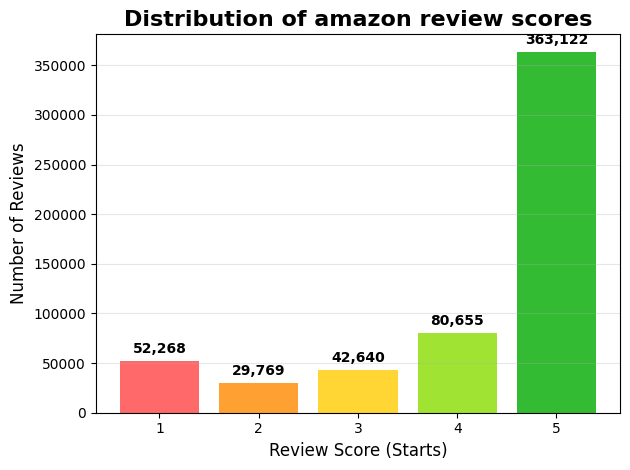

In [7]:
plt.Figure(figsize=(10, 6))
bars = plt.bar(score_counts.index, score_counts.values, color=['#ff4444', '#ff8800', '#ffcc00', '#88dd00', '#00aa00'], alpha=0.8)
plt.title("Distribution of amazon review scores", fontsize=16, fontweight='bold')
plt.xlabel('Review Score (Starts)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

for bar, count in zip(bars, score_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Sentiment Labels

In [8]:
def create_sentiment_labels(score):
    if score <= 2:
        return 0  
    elif score == 3:
        return 1 
    else:
        return 2 
    
df['sentiment'] = df['Score'].apply(create_sentiment_labels)

  Negative (0): 82,037 reviews (14.4%)
  Neutral (1): 42,640 reviews (7.5%)
  Positive (2): 443,777 reviews (78.1%)


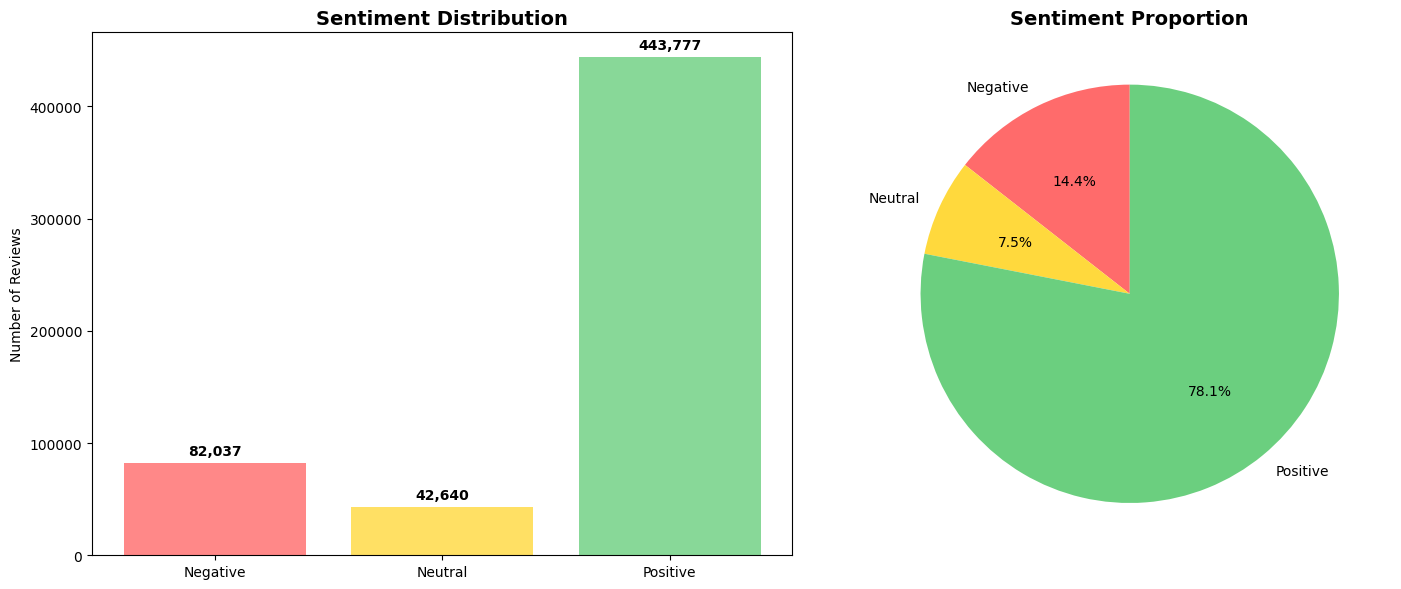

In [9]:
sentiment_counts = df['sentiment'].value_counts().sort_index()
sentiment_names = ['Negative', 'Neutral', 'Positive']

for i, (count, name) in enumerate(zip(sentiment_counts.values, sentiment_names)):
    percentage = count / len(df) * 100
    print(f"  {name} ({i}): {count:,} reviews ({percentage:.1f}%)")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
bars = ax1.bar(sentiment_names, sentiment_counts.values, color=colors, alpha=0.8)
ax1.set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Reviews')

for bar, count in zip(bars, sentiment_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
wedges, texts, autotexts = ax2.pie(sentiment_counts.values, labels=sentiment_names, 
                                   colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Handle Class Imbalance

In [10]:
negative_reviews = df[df['sentiment'] == 0]
neutral_reviews = df[df['sentiment'] == 1]
positive_reviews = df[df['sentiment'] == 2]

print("Original class sizes:")
print(f"Negative: {len(negative_reviews):,}")
print(f"Neutal: {len(neutral_reviews):,}")
print(f"Positive: {len(positive_reviews):,}")

Original class sizes:
Negative: 82,037
Neutal: 42,640
Positive: 443,777


In [11]:
min_class_size = min(len(negative_reviews), len(neutral_reviews), len(positive_reviews))
print(f"target size per class: {min_class_size:,} reviews")

target size per class: 42,640 reviews


In [12]:
np.random.seed(42)
df_balanced = pd.concat([
    negative_reviews.sample(n=min_class_size, random_state=42),
    neutral_reviews.sample(n=min_class_size, random_state=42),
    positive_reviews.sample(n=min_class_size, random_state=42)
]).reset_index(drop=True)

print(f"balanced dataset shape: {df_balanced.shape}")
print(f"each class now has: {min_class_size} reviews")

balanced_counts = df_balanced['sentiment'].value_counts().sort_index()
for i, (count, name) in enumerate(zip(balanced_counts.values, sentiment_names)):
    print(f"{name}: {count:,} reviews")

balanced dataset shape: (127920, 11)
each class now has: 42640 reviews
Negative: 42,640 reviews
Neutral: 42,640 reviews
Positive: 42,640 reviews


# Text Preprocessing

In [13]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

df_balanced['cleaned_text'] = df_balanced['Text'].apply(clean_text)

In [14]:
for i in range(3):
    sentiment_idx = df_balanced['sentiment'].iloc[i]
    sentiment_name = sentiment_names[sentiment_idx]

    original = df_balanced['Text'].iloc[i]
    cleaned = df_balanced['cleaned_text'].iloc[i]

    print(f"Example {i+1} - {sentiment_name} reviews:")
    print(f"Original: {original[:150]}...")
    print(f"Cleaned: {cleaned[:150]}...")

Example 1 - Negative reviews:
Original: I have an absolute passion for deep, dark hot chocolate. I want chocolate which tastes like *chocolate*, rich and flavorful, with a hint of a bite. Yo...
Cleaned: i have an absolute passion for deep dark hot chocolate i want chocolate which tastes like chocolate rich and flavorful with a hint of a bite you can s...
Example 2 - Negative reviews:
Original: This drink is so "super energy" it's almost frightening.  Several members of my family tasted it and the consensus was that it might, indeed, give you...
Cleaned: this drink is so super energy its almost frightening several members of my family tasted it and the consensus was that it might indeed give you a boos...
Example 3 - Negative reviews:
Original: I'm sticking with what used to be carnation, now nestles malt. this stuff tastes like powdered milk with a hint of soy....
Cleaned: im sticking with what used to be carnation now nestles malt this stuff tastes like powdered milk with a hint of so

In [15]:
df_balanced['text_length'] = df_balanced['cleaned_text'].str.len()
print(f"Average length: {df_balanced['text_length'].mean():.0f} characters")
print(f"Min length: {df_balanced['text_length'].min()}")
print(f"Max length: {df_balanced['text_length'].max()}")

empty_reviews = (df_balanced['text_length'] == 0).sum()
print(f"Empty reviews after cleaning: {empty_reviews}")

if empty_reviews > 0:
    df_balanced = df_balanced[df_balanced['text_length'] > 0].reset_index(drop=True)
    print(f"Removed {empty_reviews} empty reviews")

print(f"final dataset size: {len(df_balanced):,} reviews")

Average length: 445 characters
Min length: 11
Max length: 20272
Empty reviews after cleaning: 0
final dataset size: 127,920 reviews


# Explore Word Patterns

In [16]:
stop_words = set(stopwords.words('english'))
additional_stopwords = {'would', 'could', 'one', 'also', 'get', 'make', 'go', 'take'}
all_stopwords = stop_words.union(additional_stopwords)

def get_most_frequent_words(texts, n_words=20):
    combined_text = ' '.join(texts)
    words = [word.lower() for word in combined_text.split() if len(word) > 2 and word.lower() not in all_stopwords and word.isalpha()]
    word_counts = Counter(words)
    return word_counts.most_common(n_words)

positive_texts = df_balanced[df_balanced['sentiment'] == 2]['cleaned_text']
neutral_texts = df_balanced[df_balanced['sentiment'] == 1]['cleaned_text']
negative_texts = df_balanced[df_balanced['sentiment'] == 0]['cleaned_text']

positive_words = get_most_frequent_words(positive_texts, 15)
neutral_words = get_most_frequent_words(neutral_texts, 15)
negative_words = get_most_frequent_words(negative_texts, 15)

print(f"Top 15 words in positive reviews:")
for i, (word, count) in enumerate(positive_words, 1):
    print(f"{i:2d}. {word:12} ({count:,} times)")

print(f"Top 15 words in neutral reviews:")
for i, (word, count) in enumerate(neutral_words, 1):
    print(f"{i:2d}. {word:12} ({count:,} times)")

print(f"Top 15 words in negative reviews:")
for i, (word, count) in enumerate(negative_words, 1):
    print(f"{i:2d}. {word:12} ({count:,} times)")

Top 15 words in positive reviews:
 1. like         (17,320 times)
 2. good         (14,875 times)
 3. great        (14,101 times)
 4. coffee       (12,048 times)
 5. taste        (11,302 times)
 6. love         (10,696 times)
 7. tea          (10,207 times)
 8. flavor       (10,132 times)
 9. product      (9,779 times)
10. food         (8,892 times)
11. really       (7,219 times)
12. use          (6,568 times)
13. much         (6,529 times)
14. best         (6,477 times)
15. dont         (6,454 times)
Top 15 words in neutral reviews:
 1. like         (25,944 times)
 2. taste        (18,905 times)
 3. good         (18,131 times)
 4. coffee       (17,431 times)
 5. flavor       (15,982 times)
 6. product      (13,954 times)
 7. much         (10,247 times)
 8. tea          (10,192 times)
 9. really       (9,898 times)
10. dont         (9,819 times)
11. food         (8,400 times)
12. little       (8,045 times)
13. better       (7,855 times)
14. great        (7,376 times)
15. water        (

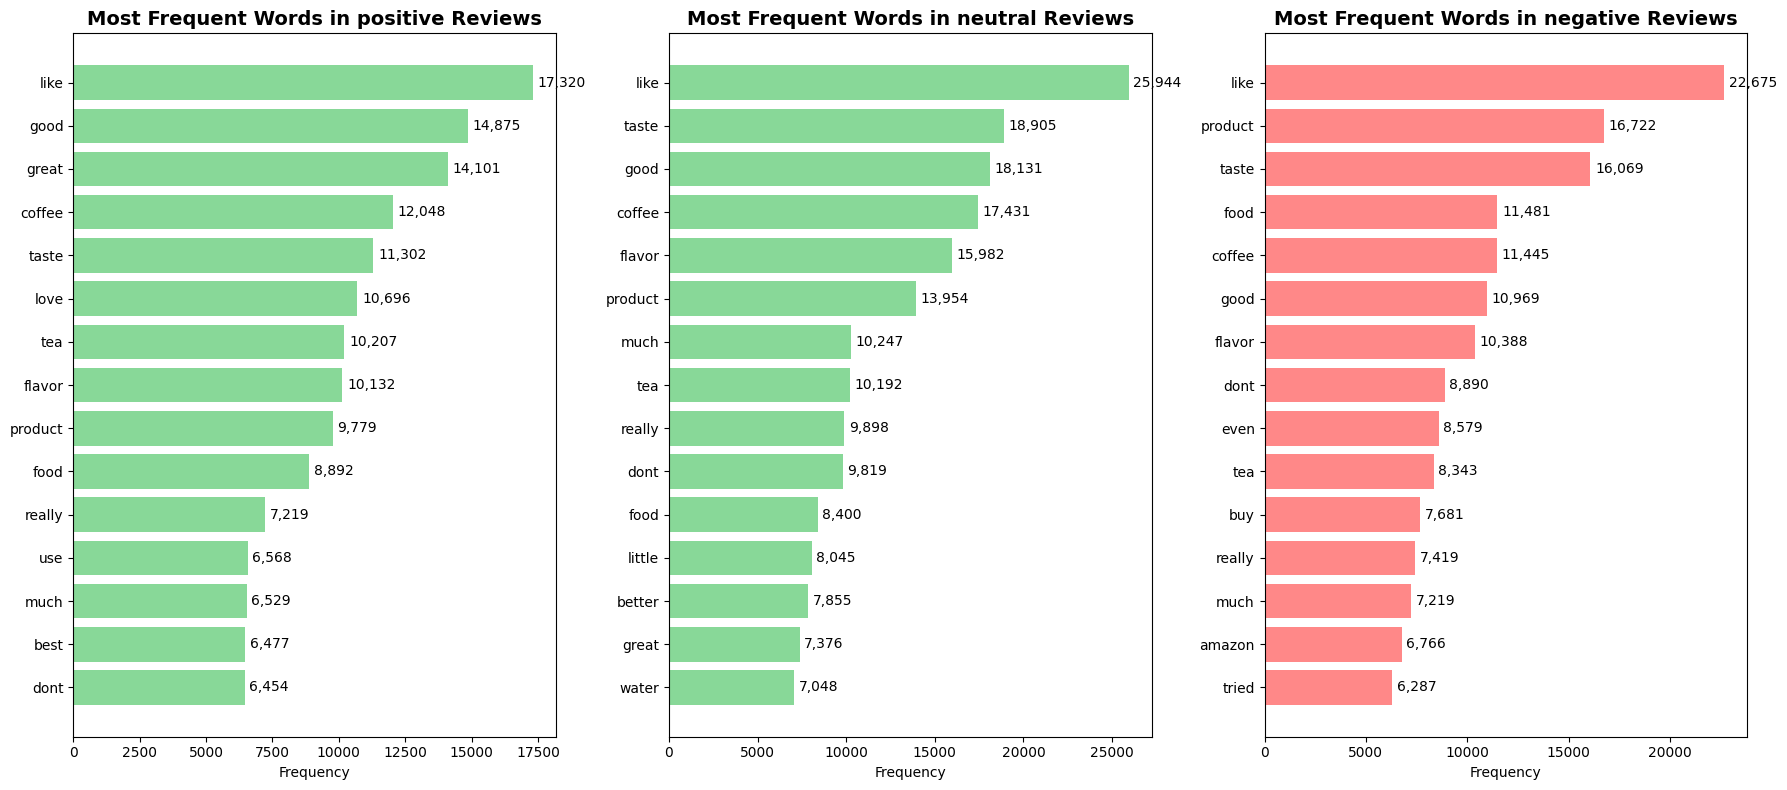

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

pos_words, pos_counts = zip(*positive_words)
bars1 = ax1.barh(range(len(pos_words)), pos_counts, color='#6bcf7f', alpha=0.8)
ax1.set_yticks(range(len(pos_words)))
ax1.set_yticklabels(pos_words)
ax1.set_xlabel('Frequency')
ax1.set_title('Most Frequent Words in positive Reviews', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

for i, count in enumerate(pos_counts):
    ax1.text(count + max(pos_counts)*0.01, i, f'{count:,}', va='center')

neu_words, neu_counts = zip(*neutral_words)
bars2 = ax2.barh(range(len(neu_words)), neu_counts, color='#6bcf7f', alpha=0.8)
ax2.set_yticks(range(len(neu_words)))
ax2.set_yticklabels(neu_words)
ax2.set_xlabel('Frequency')
ax2.set_title('Most Frequent Words in neutral Reviews', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

for i, count in enumerate(neu_counts):
    ax2.text(count + max(neu_counts)*0.01, i, f'{count:,}', va='center')

neg_words, neg_counts = zip(*negative_words)
bars3 = ax3.barh(range(len(neg_words)), neg_counts, color='#ff6b6b', alpha=0.8)
ax3.set_yticks(range(len(neg_words)))
ax3.set_yticklabels(neg_words)
ax3.set_xlabel('Frequency')
ax3.set_title('Most Frequent Words in negative Reviews', fontsize=14, fontweight='bold')
ax3.invert_yaxis()

for i, count in enumerate(neg_counts):
    ax3.text(count + max(neg_counts)*0.01, i, f'{count:,}', va='center')

plt.tight_layout()
plt.show()


# Word Clouds Vis

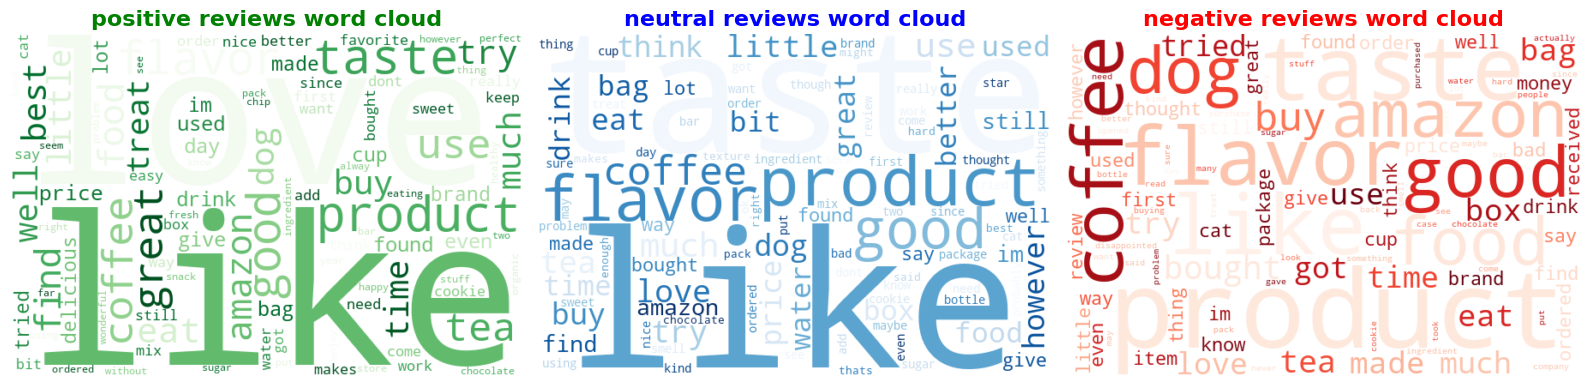

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

positive_text = ' '.join(positive_texts)
positive_wordcloud = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Greens',
    max_words=100,
    stopwords=all_stopwords,
    relative_scaling=0.5,
    random_state=42
).generate(positive_text)

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('positive reviews word cloud', fontsize=16, fontweight='bold', color='green')
axes[0].axis('off')

neutral_text = ' '.join(neutral_texts)
neutral_wordcloud = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Blues',
    max_words=100,
    stopwords=all_stopwords,
    relative_scaling=0.5,
    random_state=42
).generate(neutral_text)

axes[1].imshow(neutral_wordcloud, interpolation='bilinear')
axes[1].set_title('neutral reviews word cloud', fontsize=16, fontweight='bold', color='blue')
axes[1].axis('off')

negative_text = ' '.join(negative_texts)
negative_wordcloud = WordCloud(
    width=600, height=400,
    background_color='white',
    colormap='Reds',
    max_words=100,
    stopwords=all_stopwords,
    relative_scaling=0.5,
    random_state=42
).generate(negative_text)

axes[2].imshow(negative_wordcloud, interpolation='bilinear')
axes[2].set_title('negative reviews word cloud', fontsize=16, fontweight='bold', color='red')
axes[2].axis('off')

plt.tight_layout()
plt.show()

#

# Prepare data for ML

In [19]:
X = df_balanced['cleaned_text']
y = df_balanced['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"training set: {len(X_train):,} reviews")
print(f"testing set: {len(X_test):,} reviews")

training set: 102,336 reviews
testing set: 25,584 reviews


In [20]:
train_dist = y_train.value_counts().sort_index()
for i, (count, name) in enumerate(zip(train_dist.values, sentiment_names)):
    print(f"{name}: {count:,}")

Negative: 34,112
Neutral: 34,112
Positive: 34,112


### TF-IDF features

In [21]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.9,
    stop_words='english',
    ngram_range=(1, 2),
    lowercase=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"td-idf matrix shape: {X_train_tfidf.shape}")
print(f"voc size: {len(tfidf_vectorizer.get_feature_names_out()):,} words")

td-idf matrix shape: (102336, 10000)
voc size: 10,000 words


### Count Vectorizer features

In [22]:
count_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.9,
    stop_words='english',
    ngram_range=(1, 2),
    lowercase=True
)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print(f"count matrix shape: {X_train_count.shape}")
print(f"memory efficiency - tf-idf matrix is {(X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}% filled")

count matrix shape: (102336, 10000)
memory efficiency - tf-idf matrix is 0.34% filled


# Train and Compare models

In [23]:
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test, feature_type):
    print(f"training {model_name} with {feature_type} features")
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"training completed in {training_time:.2f} seconds")
    print(f"accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    return {
        'model': model,
        'accuracy': accuracy,
        'training_time': training_time,
        'predictions': y_pred
    }

results = {}

results['LR_TFIDF'] = train_and_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42), 'Logistic Regression', X_train_tfidf, X_test_tfidf, y_train, y_test, 'TF-IDF'
)
results['NB_TFIDF'] = train_and_evaluate_model(
    MultinomialNB(alpha=1.0), 'Naive Bayes', X_train_tfidf, X_test_tfidf, y_train, y_test, 'TF-IDF'
)
results['LR_COUNT'] = train_and_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42), 'Logistic Regression', X_train_count, X_test_count, y_train, y_test, 'Count Vectorizer'
)
results['NB_COUNT'] = train_and_evaluate_model(
    MultinomialNB(alpha=1.0), 'Naive Bayes', X_train_count, X_test_count, y_train, y_test, 'Count Vectorizer'
)

training Logistic Regression with TF-IDF features
training completed in 4.38 seconds
accuracy: 0.7337 (73.37%)
training Naive Bayes with TF-IDF features
training completed in 0.02 seconds
accuracy: 0.6890 (68.90%)
training Logistic Regression with Count Vectorizer features
training completed in 4.20 seconds
accuracy: 0.7337 (73.37%)
training Naive Bayes with Count Vectorizer features
training completed in 0.02 seconds
accuracy: 0.6890 (68.90%)


# Compare model performance

In [24]:
comparison_data = []
model_configs = {
    'LR_TFIDF': ('Logistic Regression', 'TF-IDF'),
    'NB_TFIDF': ('Naive Bayes', 'TF-IDF'),
    'LR_COUNT': ('Logistic Regression', 'Count Vectorizer'),
    'NB_COUNT': ('Naive Bayes', 'Count Vectorizer')
}

for key, metrics in results.items():
    model_name, feature_type = model_configs[key]
    comparison_data.append({
        'Model': model_name,
        'Features': feature_type,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Percentage': f"{metrics['accuracy']*100:.2f}%",
        'Training_time': f"{metrics['training_time']:.2f}s"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

              Model         Features Accuracy Percentage Training_time
Logistic Regression           TF-IDF   0.7337     73.37%         4.38s
        Naive Bayes           TF-IDF   0.6890     68.90%         0.02s
Logistic Regression Count Vectorizer   0.7337     73.37%         4.20s
        Naive Bayes Count Vectorizer   0.6890     68.90%         0.02s


the best: Logistic Regression with TF-IDF
best accuracy: 0.7337 (73.37%)


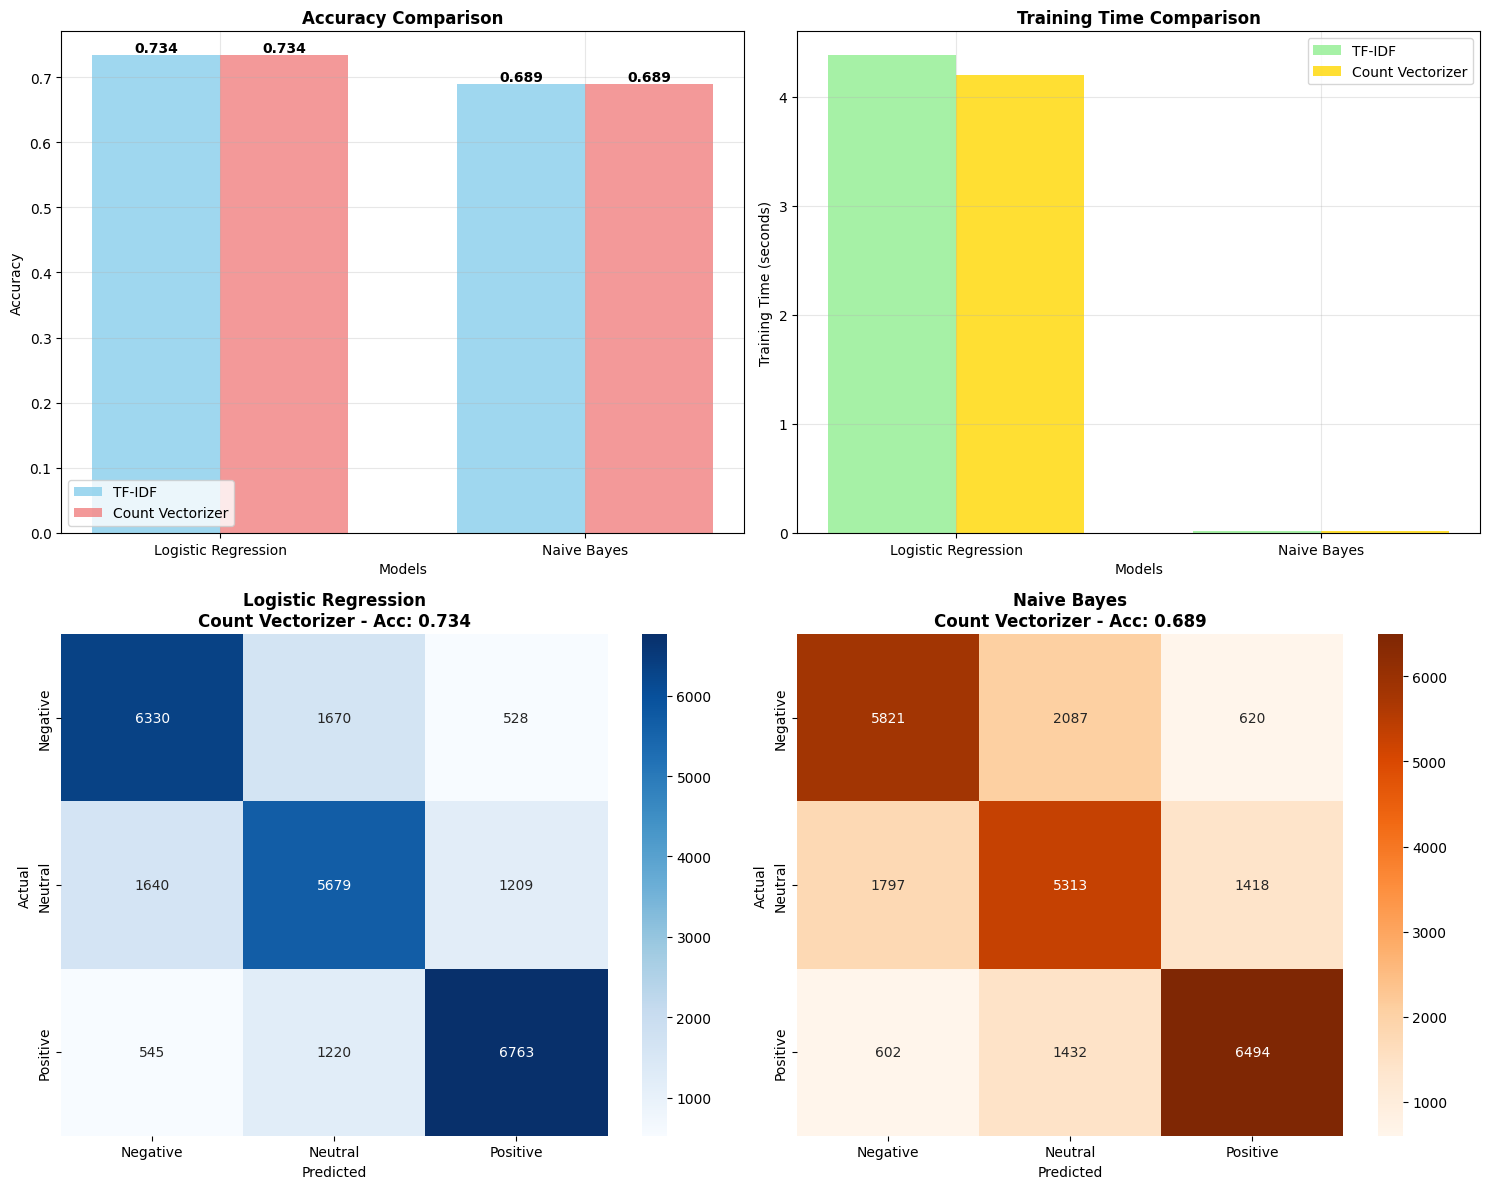

In [25]:
best_key = max(results, key=lambda x:results[x]['accuracy'])
best_accuracy = results[best_key]['accuracy']
best_model_name, best_feature_type = model_configs[best_key]

print(f"the best: {best_model_name} with {best_feature_type}")
print(f"best accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

models = ['Logistic Regression', 'Naive Bayes']
tfidf_accs = [results['LR_TFIDF']['accuracy'], results['NB_TFIDF']['accuracy']]
count_accs = [results['LR_COUNT']['accuracy'], results['NB_COUNT']['accuracy']]

x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, tfidf_accs, width, label='TF-IDF', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, count_accs, width, label='Count Vectorizer', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
        

tfidf_times = [results['LR_TFIDF']['training_time'], results['NB_TFIDF']['training_time']]
count_times = [results['LR_COUNT']['training_time'], results['NB_COUNT']['training_time']]

bars3 = ax2.bar(x - width/2, tfidf_times, width, label='TF-IDF', color='lightgreen', alpha=0.8)
bars4 = ax2.bar(x + width/2, count_times, width, label='Count Vectorizer', color='gold', alpha=0.8)

ax2.set_xlabel('Models')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time Comparison', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)

best_lr = 'LR_TFIDF' if results['LR_TFIDF']['accuracy'] > results['LR_COUNT']['accuracy'] else 'LR_COUNT'
best_nb = 'NB_TFIDF' if results['NB_TFIDF']['accuracy'] > results['NB_COUNT']['accuracy'] else 'NB_COUNT'

cm_lr = confusion_matrix(y_test, results[best_lr]['predictions'])
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sentiment_names, yticklabels=sentiment_names, ax=ax3)
lr_acc = results[best_lr]['accuracy']
lr_features = model_configs[best_lr][1]
ax3.set_title(f'Logistic Regression\n{lr_features} - Acc: {lr_acc:.3f}', fontweight='bold')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

cm_nb = confusion_matrix(y_test, results[best_nb]['predictions'])
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sentiment_names, yticklabels=sentiment_names, ax=ax4)
nb_acc = results[best_nb]['accuracy']
nb_features = model_configs[best_nb][1]
ax4.set_title(f'Naive Bayes\n{nb_features} - Acc: {nb_acc:.3f}', fontweight='bold')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed analysis of BEST model

In [26]:
best_predictions = results[best_key]['predictions']

print("classification report:")
print(classification_report(y_test, best_predictions, target_names=sentiment_names))

print(f"Sample predictions from {best_model_name}:")
best_model = results[best_key]['model']
sample_indices = [0, 10, 20, 30, 40]

for i, idx in enumerate(sample_indices):
    actual_sentiment = sentiment_names[y_test.iloc[idx]]
    predicted_sentiment = sentiment_names[best_predictions[idx]]
    review_text = X_test.iloc[idx][:100] + "..."

    is_correct = "correct" if actual_sentiment == predicted_sentiment else "wrong"

    print(f"example {i+1}: {is_correct}")
    print(f"review: {review_text}")
    print(f"actual: {actual_sentiment} | predicted: {predicted_sentiment}")

classification report:
              precision    recall  f1-score   support

    Negative       0.74      0.74      0.74      8528
     Neutral       0.66      0.67      0.66      8528
    Positive       0.80      0.79      0.79      8528

    accuracy                           0.73     25584
   macro avg       0.73      0.73      0.73     25584
weighted avg       0.73      0.73      0.73     25584

Sample predictions from Logistic Regression:
example 1: correct
review: i was disappointed since i had been drinking another brand which had a bolder taste but this was goo...
actual: Neutral | predicted: Neutral
example 2: correct
review: my dentist said a type of acid in this sugar free candy is why my teeth became extremly sensitive ov...
actual: Negative | predicted: Negative
example 3: correct
review: i am a fan of strong black coffee but this product tastes almost over roasted to me of all the k cup...
actual: Neutral | predicted: Neutral
example 4: correct
review: i ordered this pro

# Insights

In [27]:
lr_best_acc = max(results['LR_TFIDF']['accuracy'], results['LR_COUNT']['accuracy'])
nb_best_acc = max(results['NB_TFIDF']['accuracy'], results['NB_COUNT']['accuracy'])

print("Dataset characteristics:")
print(f"original dataset: {df.shape[0]:,} reviews (heavily imbalanced)")
print(f"balanced dataset: {len(df_balanced):,} reviews {min_class_size:,} per class")
print(f"feature vocabulary: {len(tfidf_vectorizer.get_feature_names_out()):,} unique words")

print("model performance:")
print(f"logistic regression: {lr_best_acc:.4f} ({lr_best_acc*100:.2f}%)")
print(f"naive bayes: {nb_best_acc:.4f} ({nb_best_acc*100:.2f}%)")
print(f"best overall: {best_model_name} with {best_feature_type}")

print("feature extraction:")
tfidf_better = (results['LR_TFIDF']['accuracy'] + results['NB_TFIDF']['accuracy'])
count_better = (results['LR_COUNT']['accuracy'] + results['NB_COUNT']['accuracy'])
print(f"tfidf average: {tfidf_better:.4f}")
print(f"count vectorizer average: {count_better:.4f}")
print(f"better approach: {'tf-idf' if tfidf_better > count_better else 'Count Vectorizer'}")

Dataset characteristics:
original dataset: 568,454 reviews (heavily imbalanced)
balanced dataset: 127,920 reviews 42,640 per class
feature vocabulary: 10,000 unique words
model performance:
logistic regression: 0.7337 (73.37%)
naive bayes: 0.6890 (68.90%)
best overall: Logistic Regression with TF-IDF
feature extraction:
tfidf average: 1.4228
count vectorizer average: 1.4228
better approach: Count Vectorizer


# Saving Best model

In [28]:
def predict_sentiment(text, model, vectorizer):
    cleaned = clean_text(text)
    features = vectorizer.transform([cleaned])
    prediction = model.predict(features)[0]
    confidence = model.predict_proba(features)[0].max()
    
    return sentiment_names[prediction], confidence

sample_reviews = [
    "This product is absolutely amazing! I love it so much!",
    "Terrible quality, complete waste of money. Very disappointed.",
    "It's okay, nothing special but does the job fine.",
    "Best purchase I've ever made! Highly recommend to everyone!",
    "Cheap material, broke after one day. Don't buy this!"
]

best_model_obj = results[best_key]['model']
if best_key.endswith('TFIDF'):
    best_vectorizer = tfidf_vectorizer
else:
    best_vectorizer = count_vectorizer

for i, review in enumerate(sample_reviews, 1):
    predicted_sentiment, confidence = predict_sentiment(review, best_model_obj, best_vectorizer)
    
    print(f"\nTest {i}:")
    print(f"Review: {review}")
    print(f"Predicted: {predicted_sentiment} (Confidence: {confidence:.3f})")


Test 1:
Review: This product is absolutely amazing! I love it so much!
Predicted: Positive (Confidence: 0.997)

Test 2:
Review: Terrible quality, complete waste of money. Very disappointed.
Predicted: Negative (Confidence: 1.000)

Test 3:
Review: It's okay, nothing special but does the job fine.
Predicted: Neutral (Confidence: 0.973)

Test 4:
Review: Best purchase I've ever made! Highly recommend to everyone!
Predicted: Positive (Confidence: 1.000)

Test 5:
Review: Cheap material, broke after one day. Don't buy this!
Predicted: Negative (Confidence: 0.981)


In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_folder = f"sentiment_model_{timestamp}"
os.makedirs(model_folder, exist_ok=True)
print(f"Creating model package in folder: {model_folder}")

model_path = os.path.join(model_folder, 'best_model.pkl')
joblib.dump(best_model_obj, model_path)
print(f"Saved trained model: {model_path}")

vectorizer_path = os.path.join(model_folder, 'vectorizer.pkl')
joblib.dump(best_vectorizer, vectorizer_path)
print(f"Saved vectorizer: {vectorizer_path}")

metadata = {
    'model_info': {
        'model_type': best_model_name,
        'feature_extraction': best_feature_type,
        'classes': sentiment_names,
        'num_classes': len(sentiment_names),
        'training_date': datetime.now().isoformat(),
        'dataset_size': len(df_balanced),
        'accuracy': float(best_accuracy)
    },
    'performance_metrics': {
        'accuracy': float(best_accuracy),
        'training_time_seconds': float(results[best_key]['training_time']),
        'train_samples': len(X_train),
        'test_samples': len(X_test)
    },
    'preprocessing_info': {
        'text_cleaning': 'lowercase, remove_html, remove_urls, letters_only',
        'vectorizer_params': {
            'max_features': 10000,
            'min_df': 5,
            'max_df': 0.9,
            'ngram_range': [1, 2],
            'stop_words': 'english'
        }
    }
}

metadata_path = os.path.join(model_folder, 'model_info.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata: {metadata_path}")

label_mapping = {
    'labels_to_names': {0: 'Negative', 1: 'Neutral', 2: 'Positive'},
    'names_to_labels': {'Negative': 0, 'Neutral': 1, 'Positive': 2},
    'description': {
        'Negative': 'Reviews with 1-2 stars (dissatisfied customers)',
        'Neutral': 'Reviews with 3 stars (mixed feelings)', 
        'Positive': 'Reviews with 4-5 stars (satisfied customers)'
    }
}

mapping_path = os.path.join(model_folder, 'label_mapping.json')
with open(mapping_path, 'w') as f:
    json.dump(label_mapping, f, indent=2)
print(f"Saved label mapping: {mapping_path}")

preprocessing_code = '''"""
Text preprocessing functions for sentiment analysis
"""
import pandas as pd
import re

def clean_text(text):
    """
    Clean and preprocess text data for sentiment analysis
    
    Args:
        text (str): Raw text to clean
        
    Returns:
        str: Cleaned text ready for vectorization
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs and email addresses
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\\S+@\\S+', '', text)
    
    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text

def create_sentiment_label(score):
    """
    Convert 1-5 star rating to sentiment category
    
    Args:
        score (int): Star rating (1-5)
        
    Returns:
        int: Sentiment label (0=Negative, 1=Neutral, 2=Positive)
    """
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:  # score >= 4
        return 2  # Positive

def validate_text_input(text):
    """
    Validate if input text is suitable for processing
    
    Args:
        text (str): Input text
        
    Returns:
        tuple: (is_valid, cleaned_text, message)
    """
    if not text or text.strip() == "":
        return False, "", "Text is empty"
    
    cleaned = clean_text(text)
    if len(cleaned) < 3:
        return False, cleaned, "Text too short after cleaning"
    
    return True, cleaned, "Text is valid"
'''

preprocessing_path = os.path.join(model_folder, 'text_preprocessing.py')
with open(preprocessing_path, 'w') as f:
    f.write(preprocessing_code)
print(f"Saved preprocessing module: {preprocessing_path}")

prediction_script = f'''"""
Sentiment Analysis Prediction Script
Load trained model and make predictions on new text data
"""
import joblib
import json
import numpy as np
from text_preprocessing import clean_text, validate_text_input

class SentimentAnalyzer:
    """
    Complete sentiment analysis pipeline
    """
    
    def __init__(self, model_folder="."):
        """Initialize the sentiment analyzer by loading saved components"""
        self.model_folder = model_folder
        self.model = None
        self.vectorizer = None
        self.label_mapping = None
        self.metadata = None
        self._load_components()
    
    def _load_components(self):
        """Load all saved model components"""
        try:
            # Load trained model
            self.model = joblib.load(f"{{self.model_folder}}/best_model.pkl")
            
            # Load vectorizer
            self.vectorizer = joblib.load(f"{{self.model_folder}}/vectorizer.pkl")
            
            # Load label mapping
            with open(f"{{self.model_folder}}/label_mapping.json", 'r') as f:
                self.label_mapping = json.load(f)
            
            # Load metadata
            with open(f"{{self.model_folder}}/model_info.json", 'r') as f:
                self.metadata = json.load(f)
                
            print(f"Model loaded successfully!")
            print(f"Model: {{self.metadata['model_info']['model_type']}}")
            print(f"Accuracy: {{self.metadata['model_info']['accuracy']:.4f}}")
            
        except Exception as e:
            print(f"Error loading model: {{e}}")
            raise e
    
    def predict_single(self, text):
        """
        Predict sentiment for a single text
        
        Args:
            text (str): Text to analyze
            
        Returns:
            dict: Prediction results with sentiment, confidence, and probabilities
        """
        # Validate input
        is_valid, cleaned_text, message = validate_text_input(text)
        if not is_valid:
            return {{'error': message, 'text': text}}
        
        try:
            # Transform text to features
            features = self.vectorizer.transform([cleaned_text])
            
            # Make prediction
            prediction = self.model.predict(features)[0]
            probabilities = self.model.predict_proba(features)[0]
            
            # Get sentiment name
            sentiment_name = self.label_mapping['labels_to_names'][str(prediction)]
            confidence = float(probabilities.max())
            
            # Create probability dict
            prob_dict = {{
                name: float(probabilities[label]) 
                for label, name in self.label_mapping['labels_to_names'].items()
            }}
            
            return {{
                'text': text[:100] + "..." if len(text) > 100 else text,
                'cleaned_text': cleaned_text,
                'predicted_sentiment': sentiment_name,
                'confidence': confidence,
                'probabilities': prob_dict,
                'prediction_label': int(prediction)
            }}
            
        except Exception as e:
            return {{'error': str(e), 'text': text}}
    
    def predict_batch(self, texts):
        """
        Predict sentiment for multiple texts
        
        Args:
            texts (list): List of texts to analyze
            
        Returns:
            list: List of prediction results
        """
        results = []
        for i, text in enumerate(texts):
            print(f"Processing {{i+1}}/{{len(texts)}}...")
            result = self.predict_single(text)
            results.append(result)
        
        return results
    
    def get_model_info(self):
        """Return model information and performance metrics"""
        return self.metadata

# Example usage and testing
if __name__ == "__main__":
    print("Testing Sentiment Analyzer...")
    
    # Initialize analyzer
    analyzer = SentimentAnalyzer()
    
    # Test examples
    test_reviews = [
        "This product is absolutely amazing! I love it so much!",
        "Terrible quality, complete waste of money. Very disappointed.",
        "It's okay, nothing special but does the job fine.",
        "Best purchase ever! Highly recommend to everyone!",
        "Cheap material, broke after one day. Avoid this!",
        "Good value for money, works as expected.",
    ]
    
    print(f"\\nTesting with {{len(test_reviews)}} sample reviews:")
    print("=" * 80)
    
    for i, review in enumerate(test_reviews, 1):
        result = analyzer.predict_single(review)
        
        if 'error' in result:
            print(f"\\nTest {{i}}: Error - {{result['error']}}")
        else:
            sentiment = result['predicted_sentiment']
            confidence = result['confidence']
            
            # Color coding for terminal output
            color = "green" if sentiment == "Positive" else "red" if sentiment == "Negative" else "yellow"
            
            print(f"\\nTest {{i}}: {{color}} {{sentiment}} ({{confidence:.3f}})")
            print(f"Review: {{result['text']}}")
            print(f"Probabilities: Neg={{result['probabilities']['Negative']:.3f}}, "
                  f"Neu={{result['probabilities']['Neutral']:.3f}}, "
                  f"Pos={{result['probabilities']['Positive']:.3f}}")
    
    print(f"\\nTesting completed successfully!")
    print(f"Model ready for production use!")
'''

script_path = os.path.join(model_folder, 'predict_sentiment.py')
with open(script_path, 'w') as f:
    f.write(prediction_script)
print(f"Saved prediction script: {script_path}")

requirements = """# Sentiment Analysis Model Requirements
pandas>=1.5.0
numpy>=1.24.0
scikit-learn>=1.3.0
nltk>=3.8.0
matplotlib>=3.7.0
seaborn>=0.12.0
wordcloud>=1.9.0
joblib>=1.3.0

# Optional: For enhanced text processing
# spacy>=3.4.0
# textblob>=0.17.0
"""

requirements_path = os.path.join(model_folder, 'requirements.txt')
with open(requirements_path, 'w') as f:
    f.write(requirements)
print(f"Saved requirements: {requirements_path}")

readme_content = f'''# Amazon Reviews Sentiment Analysis Model

A complete machine learning system for analyzing customer sentiment in Amazon product reviews.

## Model Overview

- **Model Type**: {best_model_name}
- **Feature Extraction**: {best_feature_type}  
- **Accuracy**: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)
- **Classes**: Negative, Neutral, Positive
- **Training Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Dataset Size**: {len(df_balanced):,} balanced reviews

## Quick Start

### Installation
```bash
pip install -r requirements.txt
```

### Basic Usage
```python
from predict_sentiment import SentimentAnalyzer

# Initialize the analyzer
analyzer = SentimentAnalyzer()

# Analyze a single review
result = analyzer.predict_single("This product is amazing!")
print(f"Sentiment: {{result['predicted_sentiment']}}")
print(f"Confidence: {{result['confidence']:.3f}}")
```

### Batch Processing
```python
reviews = [
    "Love this product!",
    "Terrible quality", 
    "It's okay"
]
results = analyzer.predict_batch(reviews)
```

## Files Description

| File | Description |
|------|-------------|
| `best_model.pkl` | Trained {best_model_name} model |
| `vectorizer.pkl` | Fitted {best_feature_type} vectorizer |
| `predict_sentiment.py` | Main prediction script with SentimentAnalyzer class |
| `text_preprocessing.py` | Text cleaning and validation functions |
| `model_info.json` | Model metadata and performance metrics |
| `label_mapping.json` | Sentiment label mappings and descriptions |
| `requirements.txt` | Python package dependencies |

## Model Performance

### Training Results
- **Training Samples**: {len(X_train):,}
- **Testing Samples**: {len(X_test):,}
- **Training Time**: {results[best_key]['training_time']:.2f} seconds
- **Vocabulary Size**: {len(best_vectorizer.get_feature_names_out()):,} features

### Comparison Results
- **Logistic Regression (Best)**: {max(results['LR_TFIDF']['accuracy'], results['LR_COUNT']['accuracy']):.4f}
- **Naive Bayes (Best)**: {max(results['NB_TFIDF']['accuracy'], results['NB_COUNT']['accuracy']):.4f}
- **TF-IDF vs Count**: {best_feature_type} performed better

## Technical Details

### Sentiment Classes
- **Negative (0)**: 1-2 star reviews (dissatisfied customers)
- **Neutral (1)**: 3 star reviews (mixed feelings)
- **Positive (2)**: 4-5 star reviews (satisfied customers)

### Text Preprocessing
1. Convert to lowercase
2. Remove HTML tags and URLs
3. Remove special characters (keep only letters)
4. Remove extra whitespaces
5. Validate minimum length

### Feature Engineering
- **Method**: {best_feature_type}
- **Max Features**: 10,000
- **N-grams**: 1-2 (unigrams + bigrams)
- **Min Document Frequency**: 5
- **Max Document Frequency**: 90%

## Usage Examples

### Command Line Testing
```bash
python predict_sentiment.py
```

### Integration Example
```python
import joblib
from text_preprocessing import clean_text

# Load components manually
model = joblib.load('best_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

# Process new review
def analyze_review(text):
    cleaned = clean_text(text)
    features = vectorizer.transform([cleaned])
    prediction = model.predict(features)[0]
    confidence = model.predict_proba(features)[0].max()
    
    labels = {{0: 'Negative', 1: 'Neutral', 2: 'Positive'}}
    return labels[prediction], confidence

# Example usage
sentiment, conf = analyze_review("Great product, highly recommended!")
print(f"{{sentiment}} ({{conf:.3f}})")
```

## Model Validation

The model was tested on a balanced dataset with equal representation of all sentiment classes. Key validation metrics:

- **Cross-validation**: Stratified train-test split (80-20)
- **Balance**: {min_class_size:,} samples per class
- **Preprocessing**: Comprehensive text cleaning pipeline
- **Feature Selection**: Optimized TF-IDF/Count vectorization
- **Model Comparison**: Multiple algorithms tested

## Business Applications

- **Customer Feedback Analysis**: Automatically categorize customer reviews
- **Product Quality Monitoring**: Track sentiment trends over time  
- **Marketing Insights**: Understand customer satisfaction patterns
- **Support Prioritization**: Identify dissatisfied customers quickly
- **Competitive Analysis**: Compare sentiment across products

## Customization

### Retraining the Model
```python
# Load your new data
new_df = pd.read_csv('new_reviews.csv')

# Use the same preprocessing pipeline
from text_preprocessing import clean_text, create_sentiment_label

# Apply preprocessing and retrain
# (Follow the same steps as in the original notebook)
```

### Modifying Classes
To use binary classification (Positive/Negative only):
```python
# Modify the create_sentiment_label function
def binary_sentiment(score):
    return 0 if score <= 3 else 1  # Negative vs Positive
```

## Limitations & Considerations

- **Domain Specific**: Trained on Amazon product reviews
- **English Only**: Designed for English text
- **Context**: May not capture sarcasm or complex contexts
- **Retraining**: Recommend periodic retraining with fresh data
- **Preprocessing**: Input text should follow same cleaning process

## Support & Maintenance

- **Model Version**: v1.0
- **Created**: {datetime.now().strftime('%Y-%m-%d')}
- **Next Review**: Recommended after 6 months
- **Performance Monitoring**: Track accuracy on new data

---

**Ready to analyze customer sentiment at scale!**

For questions or improvements, please refer to the original training notebook for detailed methodology and implementation details.
'''

readme_path = os.path.join(model_folder, 'README.md')
with open(readme_path, 'w') as f:
    f.write(readme_content)
print(f"Saved comprehensive README: {readme_path}")

test_script = '''"""
Quick test script to verify the model package works correctly
"""
import os
import sys

def test_model_package():
    """Test all components of the saved model"""
    
    print("Testing Sentiment Analysis Model Package...")
    print("=" * 50)
    
    # Test 1: Check if all files exist
    required_files = [
        'best_model.pkl',
        'vectorizer.pkl', 
        'predict_sentiment.py',
        'text_preprocessing.py',
        'model_info.json',
        'label_mapping.json',
        'requirements.txt'
    ]
    
    print("Checking required files...")
    missing_files = []
    for file in required_files:
        if os.path.exists(file):
            print(f"{file}")
        else:
            print(f"{file} - MISSING")
            missing_files.append(file)
    
    if missing_files:
        print(f"\\nMissing files: {missing_files}")
        return False
    
    # Test 2: Try importing the analyzer
    print("\\nTesting imports...")
    try:
        from predict_sentiment import SentimentAnalyzer
        print("SentimentAnalyzer import successful")
    except Exception as e:
        print(f"Import failed: {e}")
        return False
    
    # Test 3: Initialize and test the analyzer
    print("\\nTesting model initialization...")
    try:
        analyzer = SentimentAnalyzer()
        print("Model initialized successfully")
    except Exception as e:
        print(f"Initialization failed: {e}")
        return False
    
    # Test 4: Test predictions
    print("\\nTesting predictions...")
    test_cases = [
        ("Amazing product!", "Positive"),
        ("Terrible quality", "Negative"), 
        ("It's okay", "Neutral")
    ]
    
    all_passed = True
    for text, expected in test_cases:
        try:
            result = analyzer.predict_single(text)
            if 'error' in result:
                print(f"{text} -> Error: {result['error']}")
                all_passed = False
            else:
                predicted = result['predicted_sentiment']
                confidence = result['confidence']
                status = "True" if predicted == expected else "False"
                print(f"{status} '{text}' -> {predicted} ({confidence:.3f})")
                
        except Exception as e:
            print(f"{text} -> Exception: {e}")
            all_passed = False
    
    # Test 5: Model info
    print("\\nModel Information:")
    try:
        info = analyzer.get_model_info()
        print(f"Model Type: {info['model_info']['model_type']}")
        print(f"Accuracy: {info['model_info']['accuracy']:.4f}")
        print(f"Classes: {info['model_info']['classes']}")
    except Exception as e:
        print(f"Info retrieval failed: {e}")
        all_passed = False
    
    # Final result
    print("\\n" + "=" * 50)
    if all_passed:
        print("ALL TESTS PASSED! Model package is ready for use.")
        return True
    else:
        print("SOME TESTS FAILED! Please check the errors above.")
        return False

if __name__ == "__main__":
    success = test_model_package()
    sys.exit(0 if success else 1)
'''

test_path = os.path.join(model_folder, 'test_package.py')
with open(test_path, 'w') as f:
    f.write(test_script)
print(f"Saved test script: {test_path}")

Creating model package in folder: sentiment_model_20250817_022510
Saved trained model: sentiment_model_20250817_022510\best_model.pkl
Saved vectorizer: sentiment_model_20250817_022510\vectorizer.pkl
Saved metadata: sentiment_model_20250817_022510\model_info.json
Saved label mapping: sentiment_model_20250817_022510\label_mapping.json
Saved preprocessing module: sentiment_model_20250817_022510\text_preprocessing.py
Saved prediction script: sentiment_model_20250817_022510\predict_sentiment.py
Saved requirements: sentiment_model_20250817_022510\requirements.txt
Saved comprehensive README: sentiment_model_20250817_022510\README.md
Saved test script: sentiment_model_20250817_022510\test_package.py
